# Introduction

In [1]:
import inspect
import math
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
# gui
import qgrid
import seaborn as sns
# pyro & pytorch
import torch
import torch.distributions.constraints as constraints
from ipywidgets import fixed, interact
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
# loading & saving data
from scipy.io import loadmat
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

%matplotlib inline
qgrid.enable()
pyro.enable_validation(True)

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.is_available()

True

In [3]:
from glimpse_read import GlimpseDataset, Sampler
from noise import (GammaNoise, GammaNoiseNoOffset, NormalNoise)
from Modelv1 import Modelv1, Modelv1p1
from Modelv2 import Modelv2
from utils import (get_offset, load_obj, save_obj, view_aoi,
                   view_aoi_class_average, view_aoi_class_summary,
                   view_aoi_summary, view_glimpse, write_summary, view_feature_summary)

In [4]:
models = {}
spot_models = {}
noise_models = {}
writers = {}

# Load Data

## Load header

In [5]:
# load header file (.mat format)
path_header = "/home/ordabayev/Documents/postdoc/Datasets/Grace-Cy3/garosen00267"
path = "/home/ordabayev/Documents/postdoc/Datasets/Grace-Cy3"
aoi_filename = "00267_integrated_green_dnaaois.dat" # green
drift_filename = "b3p81_00267_green_driftlist__manual.dat" # green

In [6]:
mat_header = loadmat(os.path.join(path_header, "header.mat"))

# convert header into dict format
header = dict()
for i, dt in  enumerate(mat_header["vid"].dtype.names):
    header[dt] = np.squeeze(mat_header["vid"][0,0][i])

# display header dictionary keys
header.keys()

dict_keys(['moviefile', 'username', 'description', 'nframes', 'time1', 'ttb', 'depth', 'offset', 'filenumber', 'width', 'height', 'camera', 'microscope', 'mversion', 'laser_names', 'filter_names', 'lasers', 'filters', 'flowrate', 'temp', 'field', 'header2', 'stagexyz'])

## Load AoI and DriftList

In [7]:
#path = "/home/ordabayev/Documents/postdoc/Bayesian_noise_files/Grace_data_Spt5_for_Yerdos"
#aoi_filename = "00267_integrated_red_dnaaois.dat" # red
#drift_filename = "00267_red_driftlist.dat" # red

In [8]:
# load aoiinfo mat file
aoi_mat = loadmat(os.path.join(path, aoi_filename))
# convert aoiinfo into DataFrame
aoi_df = pd.DataFrame(aoi_mat["aoifits"]["aoiinfo2"][0,0], columns=["frame", "ave", "x", "y", "pixnum", "aoi"])
aoi_df = aoi_df.astype({"aoi": int}).set_index("aoi")
aoi_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [9]:
# load driftlist mat file
drift_mat = loadmat(os.path.join(path, drift_filename))
# calculate the cumulative sum of dx and dy
drift_mat["driftlist"][:, 1:3] = np.cumsum(
    drift_mat["driftlist"][:, 1:3], axis=0)
# convert driftlist into DataFrame
drift_df = pd.DataFrame(drift_mat["driftlist"], columns=[
                        "frame", "dx", "dy", "timestamp"])
drift_df = drift_df.astype({"frame": int}).set_index("frame")
drift_df.head(6)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Load FrameList and Labels

In [10]:
#framelist_name = "B33p44a_FrameList_files.dat"
#framelist_mat = loadmat(os.path.join(path, framelist_name))
#print(framelist_mat.keys())
#framelist_df = pd.DataFrame(framelist_mat["FL_2226_3338_0p6OD"], columns=["aoi", "detected", "frame"])
#framelist_df = framelist_df.astype({"frame": int, "aoi": int, "detected": int})
#framelist_df

## Load AoI

In [11]:
data = GlimpseDataset(D=15, aoi_df=aoi_df, drift_df=drift_df, header=header, path=path_header)

#data.info

100%|██████████| 862/862 [00:07<00:00, 114.14it/s]


In [12]:
data.h = torch.load(os.path.join(path, "h.pt"))
data.h_beta = torch.load(os.path.join(path, "h_beta.pt"))
data.b = torch.load(os.path.join(path, "b.pt"))
data.b_beta = torch.load(os.path.join(path, "b_beta.pt"))
data.w = torch.load(os.path.join(path, "w.pt"))
data.w_beta = torch.load(os.path.join(path, "w_beta.pt"))
data.x0 = torch.load(os.path.join(path, "x0.pt"))
data.x0_scale = torch.load(os.path.join(path, "x0_scale.pt"))
data.y0 = torch.load(os.path.join(path, "y0.pt"))
data.y0_scale = torch.load(os.path.join(path, "y0_scale.pt"))

data.probs = torch.load(os.path.join(path, "probs.pt"))
data.predictions = data.probs.cpu().squeeze().detach().argmax(dim=2)

In [12]:
#labels = framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["detected"] > 0), "detected"]
#labels = labels.replace(2, 0)
#data.info["labels"] = labels.values

#data.info.head(6)

# Feature Extraction

In [12]:
# init
model_name = "Feature2"
#model_name = "GammaOffsetCPUN16F32"
# gaussian spot model + gamma noise model
spot_models[model_name] = Modelv2
noise_models[model_name] = GammaNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/{}".format(
    models[model_name].__class__.__name__)))

In [13]:
model_name = "Feature2"
#model_name = "GammaOffsetCPUN16F32"

model = models[model_name]
writer = writers[model_name]

In [14]:
pyro.clear_param_store()

optim = pyro.optim.Adam({"lr": 0.02, "betas": [0.9, 0.999]})
#elbo = TraceEnum_ELBO()
elbo = Trace_ELBO()
svi = SVI(model.feature_model, model.feature_guide, optim, loss=elbo)


writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [22]:
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx in DataLoader(Sampler(model.N), batch_size=16, shuffle=True):
        for frame_idx in DataLoader(Sampler(model.F), batch_size=model.F, shuffle=True):
            loss = svi.step(batch_idx, frame_idx)
            epoch_loss += loss * len(batch_idx) * len(frame_idx) / (model.N * model.F)
        
    #if not epoch_count % 5:
    #print(epoch_loss)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=True, mcc=False)
    epoch_count += 1
    
# cpu 22s/it
# gpu 14s/it double sampling

100%|██████████| 50/50 [07:01<00:00,  8.33s/it]


In [23]:
#data.feature = torch.zeros(data.N, data.F, 5)
#data.sd = torch.zeros(data.N, data.F, 5)

data.h = pyro.param("h_loc").detach().squeeze()
data.x0 = pyro.param("x_loc").detach().squeeze()
data.y0 = pyro.param("y_loc").detach().squeeze()
data.b = pyro.param("b_loc").detach().squeeze()
data.w = pyro.param("w_loc").detach().squeeze()

data.h_beta = pyro.param("h_beta").detach().squeeze()
data.x0_scale = pyro.param("x_scale").detach().squeeze()
data.y0_scale = pyro.param("y_scale").detach().squeeze()
data.b_beta = pyro.param("b_beta").detach().squeeze()
data.w_beta = pyro.param("w_beta").detach().squeeze()

data.gain = pyro.param("gain_v").detach().squeeze()

#data.sd[:,:,0] = torch.sqrt(pyro.param("height_loc").detach().squeeze() / pyro.param("height_beta").detach().squeeze())
#data.sd[:,:,1] = pyro.param("x0_scale").detach().squeeze()
#data.sd[:,:,2] = pyro.param("y0_scale").detach().squeeze()
#data.sd[:,:,3] = torch.sqrt(pyro.param("background_loc").detach().squeeze() / pyro.param("background_beta").detach().squeeze())
#data.sd[:,:,4] = torch.sqrt(pyro.param("width_loc").detach().squeeze() / pyro.param("width_beta").detach().squeeze())


#data.background = data.feature[:,:,3]

In [24]:
torch.save(data.h, os.path.join(path, "h.pt"))
torch.save(data.h_beta, os.path.join(path, "h_beta.pt"))
torch.save(data.b, os.path.join(path, "b.pt"))
torch.save(data.b_beta, os.path.join(path, "b_beta.pt"))
torch.save(data.w, os.path.join(path, "w.pt"))
torch.save(data.w_beta, os.path.join(path, "w_beta.pt"))
torch.save(data.x0, os.path.join(path, "x0.pt"))
torch.save(data.x0_scale, os.path.join(path, "x0_scale.pt"))
torch.save(data.y0, os.path.join(path, "y0.pt"))
torch.save(data.y0_scale, os.path.join(path, "y0_scale.pt"))

In [14]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi_summary(aoi, data, show_class=False)>

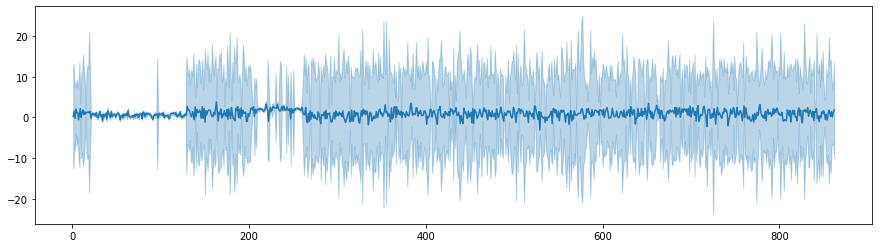

In [22]:
plt.figure(figsize=(15,4))
mean = pyro.param("x0_loc").cpu().squeeze().detach().numpy()[21]
sd = pyro.param("x0_scale").cpu().squeeze().detach().numpy()[21]
plt.plot(data.drift.index, mean)
plt.fill_between(data.drift.index, mean - sd, mean + sd, color='C0', alpha=0.3)
#plt.ylim(-5,5)

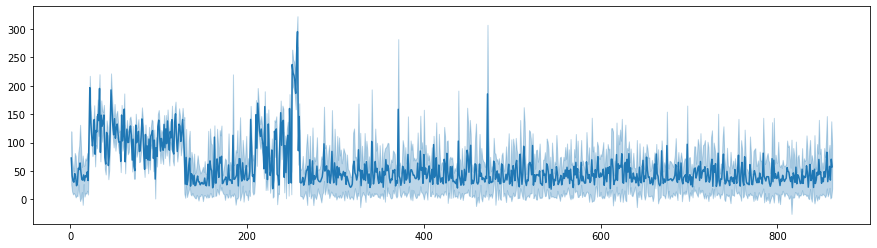

In [21]:
plt.figure(figsize=(15,4))
mean = pyro.param("height_loc").cpu().squeeze().detach().numpy()[21]
sd = pyro.param("height_scale").cpu().squeeze().detach().numpy()[21]
plt.plot(data.drift.index, mean)
plt.fill_between(data.drift.index, mean - np.sqrt(mean/sd), mean + np.sqrt(mean/sd), color='C0', alpha=0.3)
#plt.ylim(-10,10)

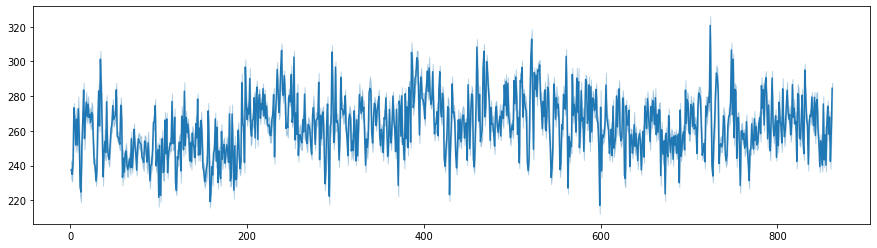

In [18]:
plt.figure(figsize=(15,4))
mean = pyro.param("background_loc").cpu().squeeze().detach().numpy()[25]
sd = pyro.param("background_scale").cpu().squeeze().detach().numpy()[25]
plt.plot(data.drift.index, mean)
plt.fill_between(data.drift.index, mean - sd, mean + sd, color='C0', alpha=0.3)
#plt.ylim(-10,10)

In [33]:
data.feature = torch.zeros(data.N, data.F, 3)

data.feature[:,:,0] = pyro.param("auto_height").detach().squeeze()
data.feature[:,:,1] = pyro.param("auto_x0").detach().squeeze()
data.feature[:,:,2] = pyro.param("auto_y0").detach().squeeze()

data.background = pyro.param("auto_background").detach().squeeze()

In [19]:
dset = pd.DataFrame(data={"height": pyro.param("auto_height").cpu().detach().squeeze().reshape(-1),
                          "x0": pyro.param("auto_x0").cpu().detach().squeeze().reshape(-1),
                          "y0": pyro.param("auto_y0").cpu().detach().squeeze().reshape(-1)
                         })

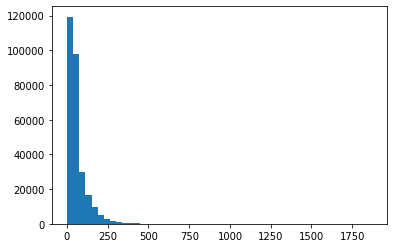

In [18]:
plt.hist(data.auto_height.reshape(-1), bins=50)
plt.show()

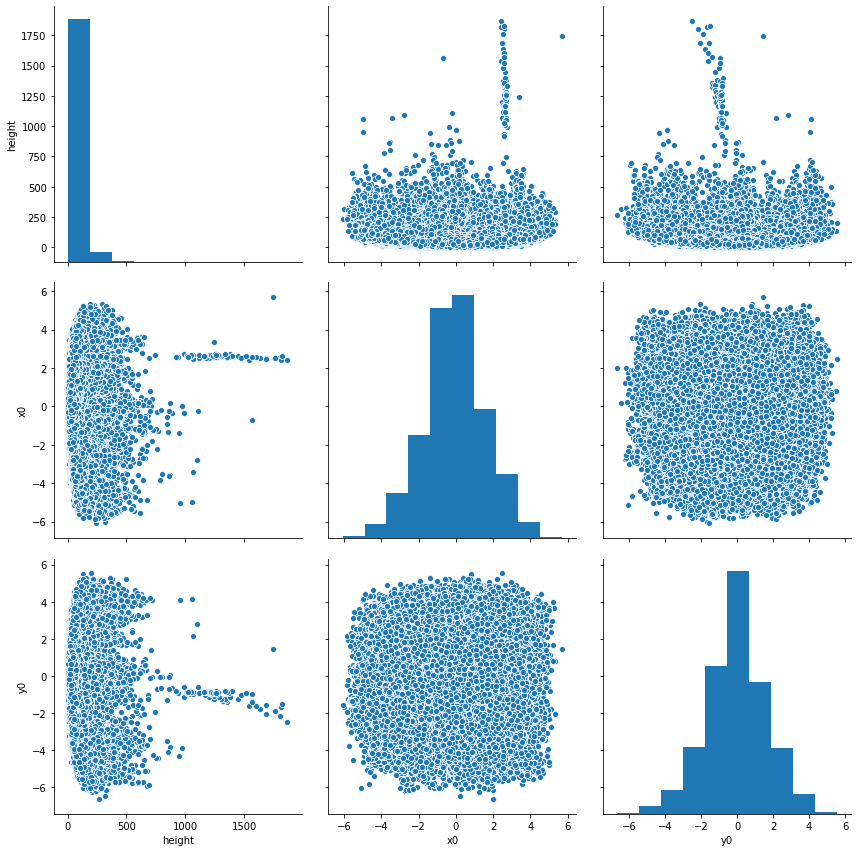

In [20]:
sns.pairplot(dset, vars=dset.columns, height=4)
plt.show()

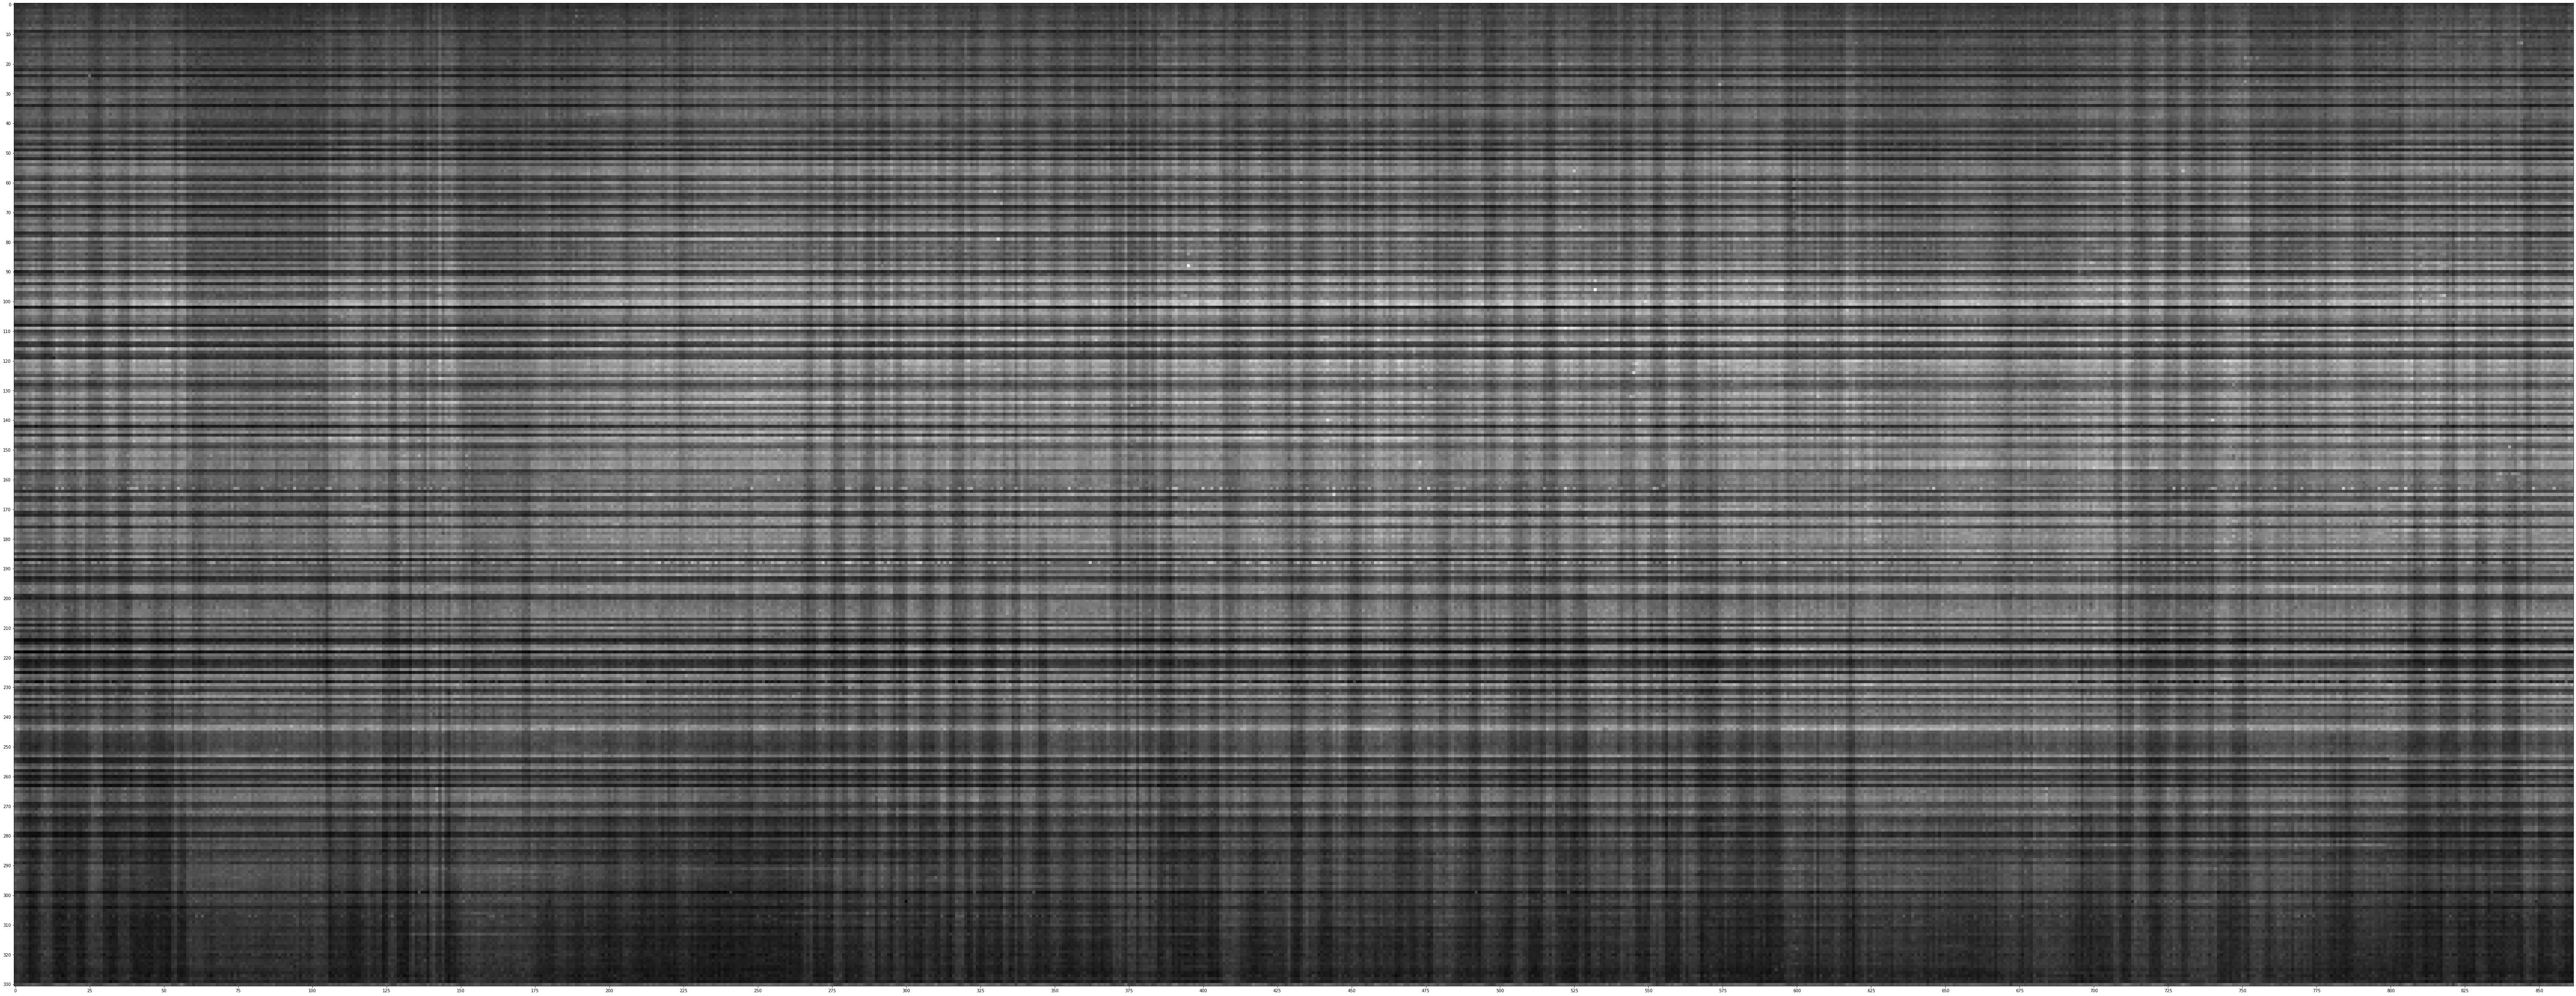

In [34]:
#%matplotlib notebook
plt.figure(figsize=(model.F/10,model.N/10))
plt.imshow(pyro.param("auto_background").cpu().detach().squeeze(), cmap="gray")
#plt.colorbar()
plt.yticks(np.arange(0,model.N,10))
plt.xticks(np.arange(0,model.F,25))
plt.tight_layout()
plt.savefig(os.path.join(path, "auto_background.png"))
plt.show()

In [41]:
pyro.param("auto_background").cpu().detach().squeeze().numpy()[:32].shape

(32, 862)

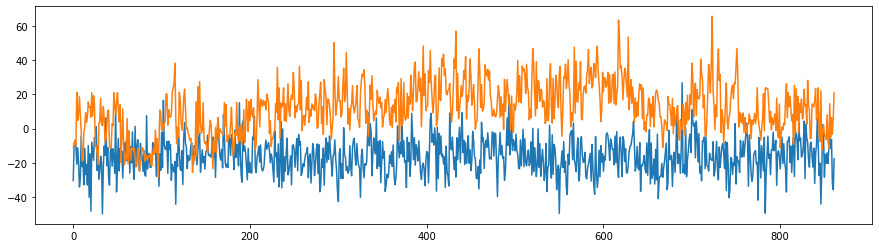

In [66]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(862), pyro.param("auto_background").cpu().detach().squeeze().numpy()[6] - 
        pyro.param("auto_background").cpu().detach().squeeze().numpy()[7])
plt.plot(np.arange(862), pyro.param("auto_background").cpu().detach().squeeze().numpy()[5] - 240)
#plt.ylim(0,)
plt.show()

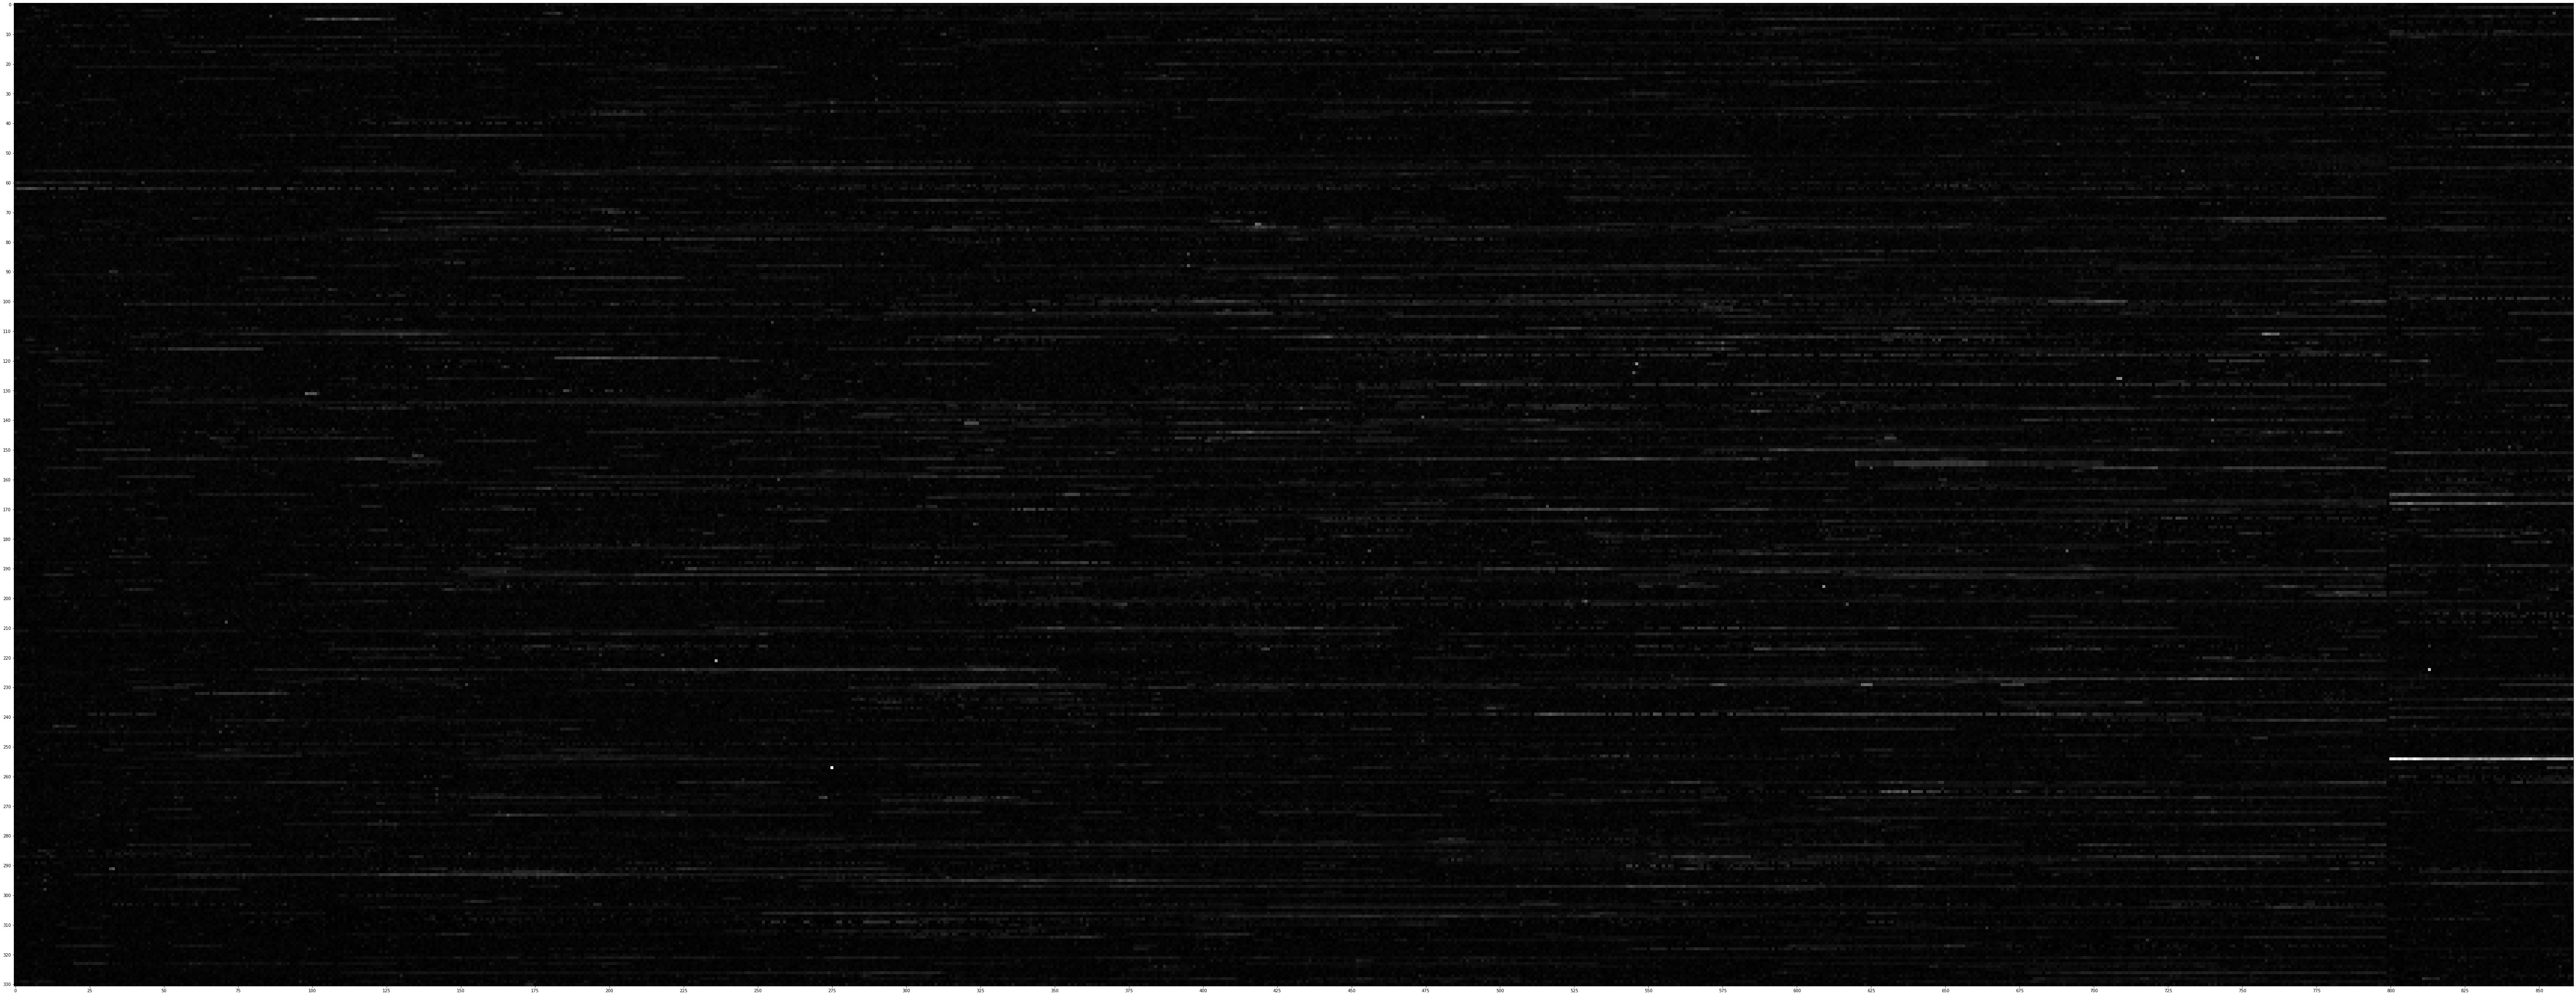

In [38]:
#%matplotlib notebook
plt.figure(figsize=(model.F/10,model.N/10))
plt.imshow(pyro.param("auto_height").cpu().detach().squeeze(), cmap="gray")
#plt.colorbar()
plt.yticks(np.arange(0,model.N,10))
plt.xticks(np.arange(0,model.F,25))
plt.tight_layout()
plt.savefig(os.path.join(path, "auto_height.png"))
plt.show()

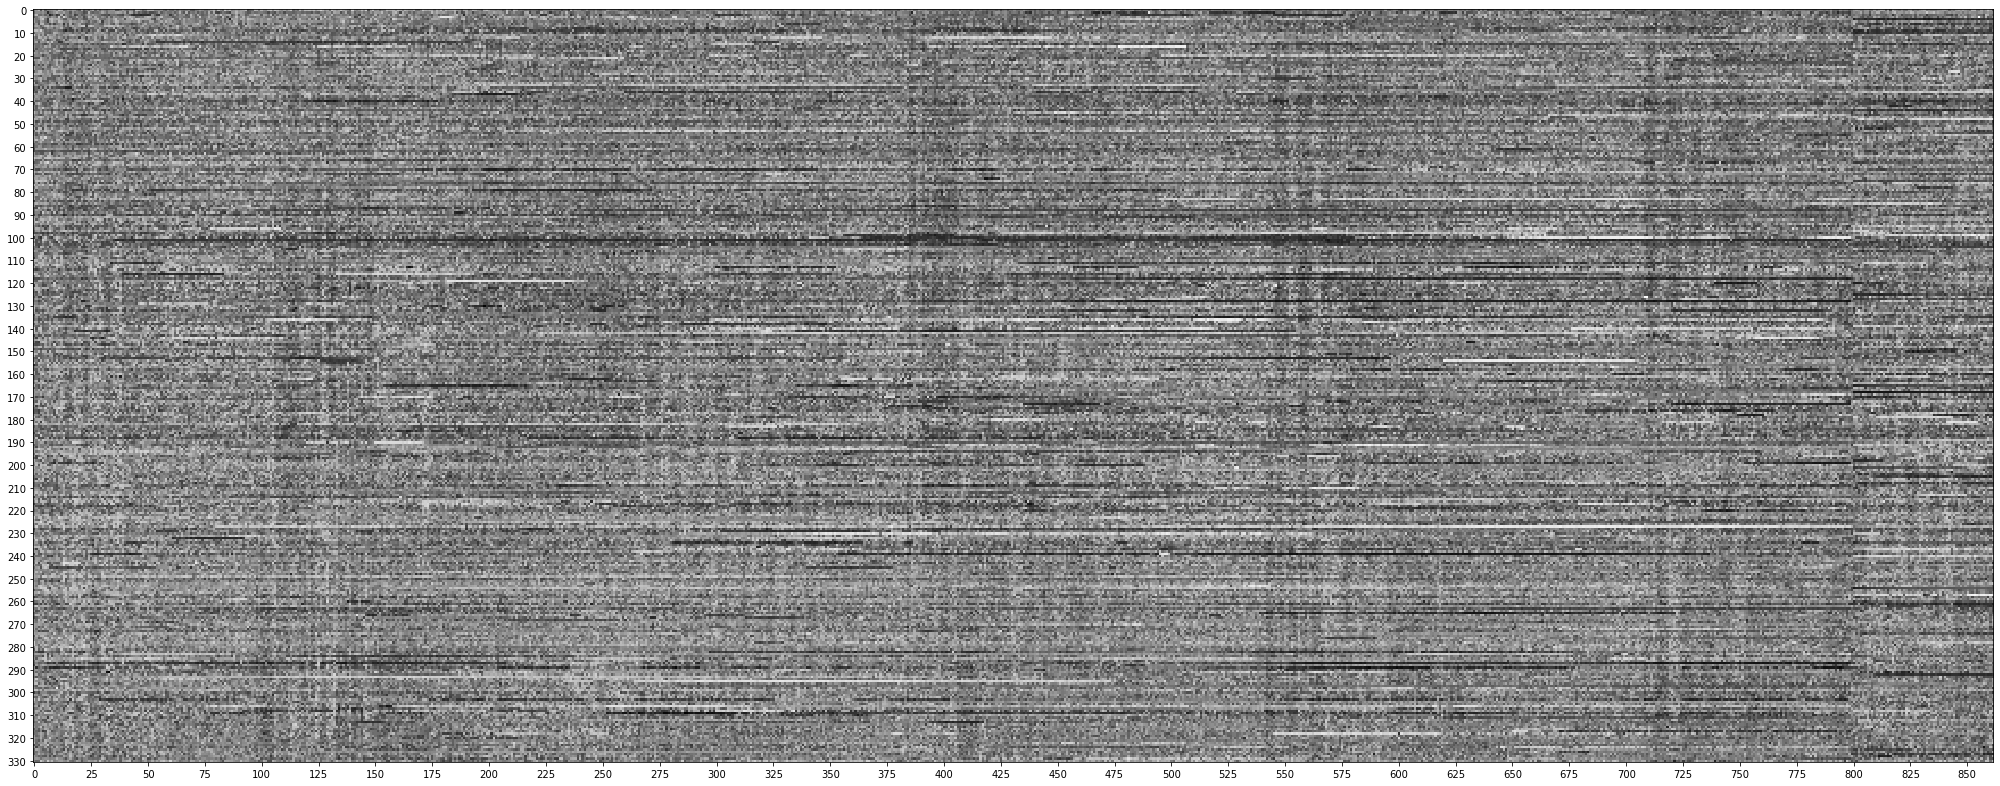

In [21]:
#%matplotlib notebook
plt.figure(figsize=(model.F/30,model.N/30))
plt.imshow(pyro.param("auto_y0").cpu().detach().squeeze(), cmap="gray")
#plt.colorbar()
plt.yticks(np.arange(0,model.N,10))
plt.xticks(np.arange(0,model.F,25))
plt.tight_layout()
plt.savefig(os.path.join(path, "auto_y.png"))
plt.show()

# Visualize data

## View glimpse images

In [11]:
#aoi_list = framelist_df["aoi"].unique()
#frame_list = framelist_df["frame"].unique()
aoi_list = aoi_df.index
frame_list = drift_df.index

interact(view_glimpse, frame=frame_list, aoi=aoi_list,
         aoi_df=fixed(aoi_df.loc[aoi_list]), drift_df=fixed(drift_df.loc[frame_list]), 
         header=fixed(header), path_glimpse=fixed(path_header),
         selected_aoi=True, all_aois=True, label=False, offset=False)

interactive(children=(Dropdown(description='frame', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

<function utils.view_glimpse(frame, aoi, aoi_df, drift_df, header, path_glimpse, selected_aoi, all_aois, label, offset)>

## View AoI

In [29]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi_summary(aoi, data, show_class=False)>

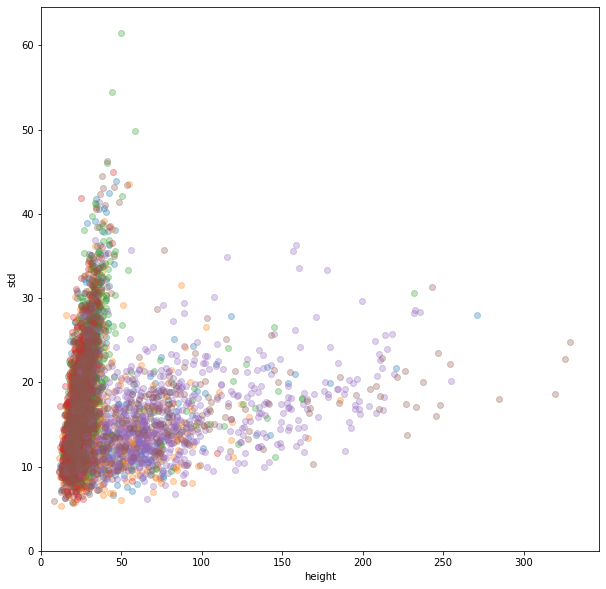

In [18]:
plt.figure(figsize=(10,10))
sd = np.sqrt(data.h[21].cpu().numpy() / data.h_beta[21].cpu().numpy())
plt.scatter(data.h[21].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[2].cpu().numpy() / data.h_beta[2].cpu().numpy())
plt.scatter(data.h[2].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[30].cpu().numpy() / data.h_beta[30].cpu().numpy())
plt.scatter(data.h[30].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[43].cpu().numpy() / data.h_beta[43].cpu().numpy())
plt.scatter(data.h[43].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[105].cpu().numpy() / data.h_beta[105].cpu().numpy())
plt.scatter(data.h[105].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.h[185].cpu().numpy() / data.h_beta[185].cpu().numpy())
plt.scatter(data.h[185].cpu().numpy(), sd, alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("height")
plt.ylabel("std")
plt.show()

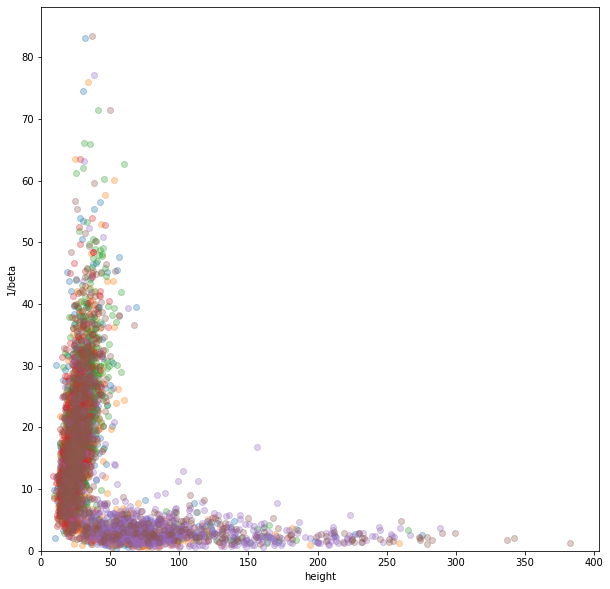

In [14]:
plt.figure(figsize=(10,10))

plt.scatter(data.h[21].cpu().numpy(), 1/data.h_beta[21].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[2].cpu().numpy(), 1/data.h_beta[2].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[30].cpu().numpy(), 1/data.h_beta[30].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[43].cpu().numpy(), 1/data.h_beta[43].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[105].cpu().numpy(), 1/data.h_beta[105].cpu().numpy(), alpha=0.3)

plt.scatter(data.h[185].cpu().numpy(), 1/data.h_beta[185].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("height")
plt.ylabel("1/beta")
plt.show()

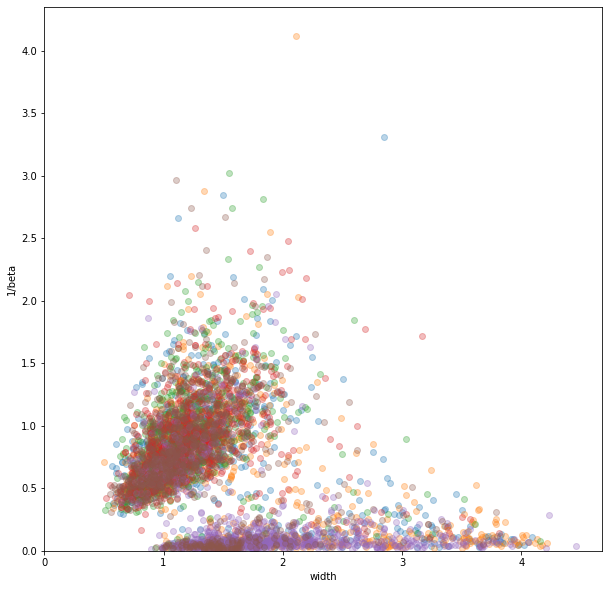

In [15]:
plt.figure(figsize=(10,10))

plt.scatter(data.w[21].cpu().numpy(), 1/data.w_beta[21].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[2].cpu().numpy(), 1/data.w_beta[2].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[30].cpu().numpy(), 1/data.w_beta[30].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[43].cpu().numpy(), 1/data.w_beta[43].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[105].cpu().numpy(), 1/data.w_beta[105].cpu().numpy(), alpha=0.3)

plt.scatter(data.w[185].cpu().numpy(), 1/data.w_beta[185].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("width")
plt.ylabel("1/beta")
plt.show()

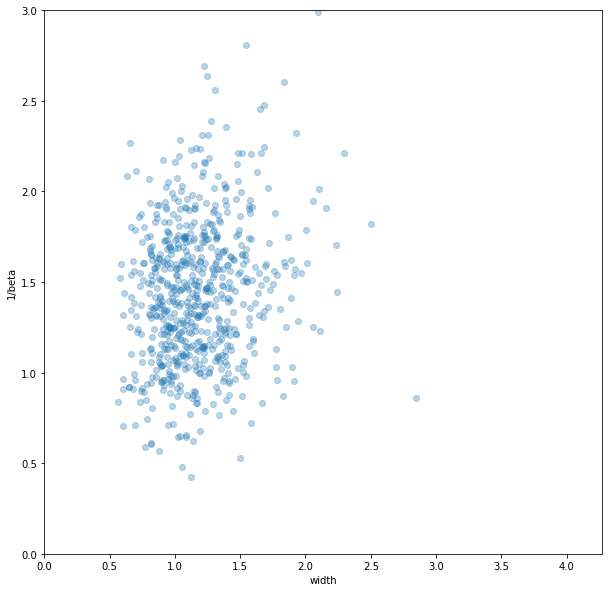

In [17]:
plt.figure(figsize=(10,10))

plt.scatter(data.w[21].cpu().numpy(), data.w[21].cpu().numpy()*data.w_beta[21].cpu().numpy(), alpha=0.3)

#plt.scatter(data.w[2].cpu().numpy(), 1/data.w_beta[2].cpu().numpy(), alpha=0.3)

#plt.scatter(data.w[30].cpu().numpy(), 1/data.w_beta[30].cpu().numpy(), alpha=0.3)

#plt.scatter(data.w[43].cpu().numpy(), 1/data.w_beta[43].cpu().numpy(), alpha=0.3)

#plt.scatter(data.w[105].cpu().numpy(), 1/data.w_beta[105].cpu().numpy(), alpha=0.3)

#plt.scatter(data.w[185].cpu().numpy(), 1/data.w_beta[185].cpu().numpy(), alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,3)
plt.xlabel("width")
plt.ylabel("1/beta")
plt.show()

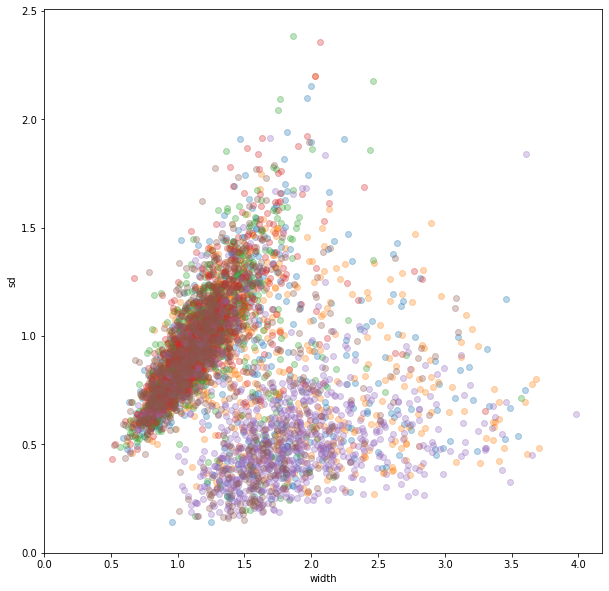

In [19]:
plt.figure(figsize=(10,10))
sd = np.sqrt(data.w[21].cpu().numpy() / data.w_beta[21].cpu().numpy())
mean = data.w[21].cpu().numpy()
plt.scatter(mean, sd, alpha=0.3)

sd = np.sqrt(data.w[2].cpu().numpy() / data.w_beta[2].cpu().numpy())
plt.scatter(data.w[2].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[30].cpu().numpy() / data.w_beta[30].cpu().numpy())
plt.scatter(data.w[30].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[43].cpu().numpy() / data.w_beta[43].cpu().numpy())
plt.scatter(data.w[43].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[105].cpu().numpy() / data.w_beta[105].cpu().numpy())
plt.scatter(data.w[105].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.w[185].cpu().numpy() / data.w_beta[185].cpu().numpy())
plt.scatter(data.w[185].cpu().numpy(), sd, alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("width")
plt.ylabel("sd")
plt.show()

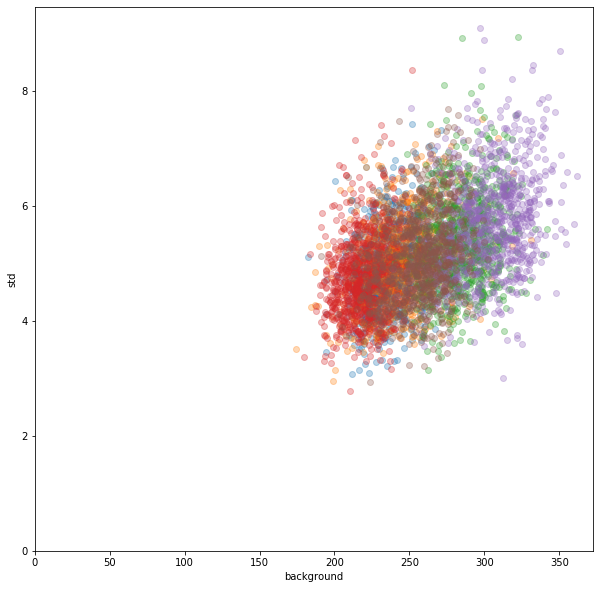

In [20]:
plt.figure(figsize=(10,10))
sd = np.sqrt(data.b[21].cpu().numpy() / data.b_beta[21].cpu().numpy())
plt.scatter(data.b[21].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.b[2].cpu().numpy() / data.b_beta[2].cpu().numpy())
plt.scatter(data.b[2].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.b[30].cpu().numpy() / data.b_beta[30].cpu().numpy())
plt.scatter(data.b[30].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.b[43].cpu().numpy() / data.b_beta[43].cpu().numpy())
plt.scatter(data.b[43].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.b[105].cpu().numpy() / data.b_beta[105].cpu().numpy())
plt.scatter(data.b[105].cpu().numpy(), sd, alpha=0.3)

sd = np.sqrt(data.b[185].cpu().numpy() / data.b_beta[185].cpu().numpy())
plt.scatter(data.b[185].cpu().numpy(), sd, alpha=0.3)

#plt.plot(data.h_beta[21].cpu().numpy())
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("background")
plt.ylabel("std")
plt.show()

In [17]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_feature_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_feature_summary(aoi, data, show_class=False)>

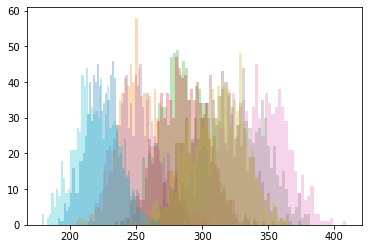

In [22]:
plt.hist(data.feature[0,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[10,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[20,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[30,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[40,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[50,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[60,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[70,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[150,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.hist(data.feature[200,:,3].cpu().numpy(), bins=50, alpha=0.3)
plt.show()

In [30]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(data), show_class=False)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi(aoi, frame, data, show_class=False)>

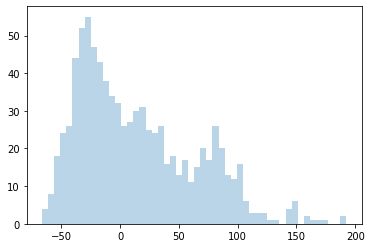

In [38]:
plt.hist(data.feature[9,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[0,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[1,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[3,:,0].cpu(), bins=50, alpha=0.3)
#plt.hist(data.feature[5,:,0].cpu(), bins=50, alpha=0.3)
#plt.plot(data.intensity.numpy()[307])
plt.show()

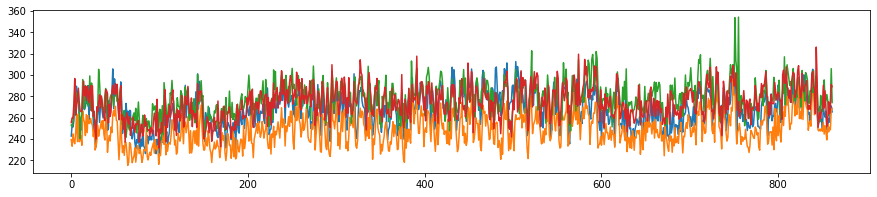

In [27]:
plt.figure(figsize=(15,3))
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[16])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[17])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[18])
plt.plot(pyro.param("auto_background").cpu().detach().squeeze().numpy()[19])
plt.show()

In [ ]:
# aoi 308 frame 450

In [52]:
offset = get_offset(drift_df.index, header, path_header)
samples, counts = np.unique(offset, return_counts=True)

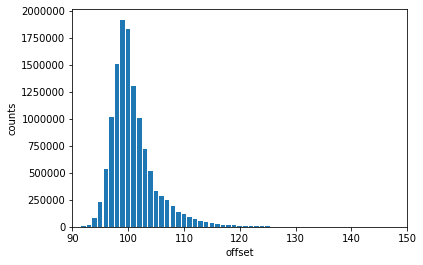

In [53]:
plt.bar(samples, counts)
plt.ylabel("counts")
plt.xlabel("offset")
plt.xlim(90,150)
plt.show()

## Determining the number of states

In [21]:
K = 2  # Fixed number of components.

pyro.clear_param_store()

@config_enumerate
def pre_model(data):
    K_plate = pyro.plate("component_axis", K, dim=-3)
    N_plate = pyro.plate("sample_axis", data.N, dim=-2)
    F_plate = pyro.plate("frame_axis", data.F, dim=-1)
    # Global variables.
    weights = pyro.sample("weights", dist.Dirichlet(0.5 * torch.ones(K)))
    with K_plate:
        Hl_loc = pyro.sample("Hl_loc", dist.HalfNormal(500.)) # K,N,1
        Hl_beta = pyro.sample("Hl_beta", dist.HalfNormal(10.))
        #Hb_loc = pyro.sample("Hb_loc", dist.HalfNormal(50.)) # K,N,1
        #Hb_beta = pyro.sample("Hb_beta", dist.HalfNormal(50.))
        x_scale = pyro.sample("x_scale", dist.HalfNormal(10.))
        y_scale = pyro.sample("y_scale", dist.HalfNormal(10.))
        #with N_plate:
        #    height_loc = pyro.sample("height_loc", dist.Gamma(Hl_loc*Hl_beta, Hl_beta)) # K,N,1
        #    height_beta = pyro.sample("height_beta", dist.Gamma(Hb_loc*Hb_beta, Hb_beta))

    nind, find = torch.tensor(np.indices((1,1)))
    nind2, find2 = torch.tensor(np.indices((1,1)))
    #noise = pyro.sample("noise", dist.HalfNormal(20.))
    with N_plate:
        #height = pyro.sample("height", dist.Normal(height_loc, height_scale)) # 2,32,1
        #print(height.shape, height_loc.shape)
        with F_plate:
            # Local variables.
            z = pyro.sample("z", dist.Categorical(weights))
            #print(height_loc[z, torch.zeros_like(z), torch.zeros_like(z)].shape)
            pyro.sample("obs_height", dist.Gamma(Hl_loc[z, nind, find]*Hl_beta[z, nind, find], 
                                                  Hl_beta[z, nind, find]), 
                        obs=data.feature[...,0])
            pyro.sample("obs_x", dist.Normal(0., x_scale[z, nind2, find2]), 
                        obs=data.feature[...,1])
            pyro.sample("obs_y", dist.Normal(0., y_scale[z, nind2, find2]), 
                        obs=data.feature[...,2])

@config_enumerate
def full_guide(data):
    K_plate = pyro.plate("component_axis", K, dim=-3)
    N_plate = pyro.plate("sample_axis", data.N, dim=-2)
    F_plate = pyro.plate("frame_axis", data.F, dim=-1)
    # Global variables.
    auto_weights = pyro.param("auto_weights", torch.ones(K)* data.N * data.F / K, constraint=constraints.positive)
    pyro.sample("weights", dist.Dirichlet(auto_weights))
    # Assume half of the data variance is due to intra-component noise.
    auto_Hl_loc = pyro.param("auto_Hl_loc", torch.rand(K,1,1)*200, constraint=constraints.positive)
    auto_Hl_beta = pyro.param("auto_Hl_beta", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_Hb_loc = pyro.param("auto_Hb_loc", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_Hb_beta = pyro.param("auto_Hb_beta", torch.ones(K,1,1), constraint=constraints.positive)
    #auto_height_loc = pyro.param("auto_height_loc", torch.rand(K,data.N,1)*200, constraint=constraints.positive)
    #auto_height_beta = pyro.param("auto_height_beta", torch.ones(K,data.N,1), constraint=constraints.positive)
    
    auto_x_scale = pyro.param("auto_x_scale", torch.ones(K,1,1), constraint=constraints.positive)
    auto_y_scale = pyro.param("auto_y_scale", torch.ones(K,1,1), constraint=constraints.positive)
    
    #auto_height = pyro.param("auto_height", torch.ones(K,data.N,1,1)*100, constraint=constraints.positive)
    
    with K_plate:
        #print(auto_locs.shape)
        pyro.sample("Hl_loc", dist.Delta(auto_Hl_loc)) # K,N,1
        pyro.sample("Hl_beta", dist.Delta(auto_Hl_beta))
        #pyro.sample("Hb_loc", dist.Delta(auto_Hb_loc)) # K,N,1
        #pyro.sample("Hb_beta", dist.Delta(auto_Hb_beta))
        pyro.sample("x_scale", dist.Delta(auto_x_scale))
        pyro.sample("y_scale", dist.Delta(auto_y_scale))
        #with N_plate:
        #    pyro.sample("height_loc", dist.Delta(auto_height_loc))
        #    pyro.sample("height_beta", dist.Delta(auto_height_beta))

    # Local variables.
    z_probs = pyro.param("z_probs", torch.ones(data.N, data.F, K) / K, constraint=constraints.simplex)
    with N_plate:
        #pyro.sample("height", dist.Delta(auto_height))
        with F_plate:
            pyro.sample("z", dist.Categorical(z_probs))

In [22]:
# init
model_name = "Classify"
#model_name = "GammaOffsetCPUN16F32"
# gaussian spot model + gamma noise model
#spot_models[model_name] = pre_model
#noise_models[model_name] = GammaNoise

#Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

#models[model_name] = pre_model # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/{}".format(model_name)))

In [23]:
model_name = "Classify"
#model_name = "GammaOffsetCPUN16F32"

#model = models[model_name]
writer = writers[model_name]

In [24]:
pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO()
svi = SVI(pre_model, full_guide, optim, loss=elbo)


#writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
#writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [25]:
n_epochs = 100

for epoch in tqdm(range(n_epochs)):
    epoch_loss = svi.step(data)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=False, mcc=False)
    epoch_count += 1
    #print(loss)

100%|██████████| 100/100 [00:11<00:00,  9.24it/s]


In [39]:
data.std()

tensor(28.1474)

In [83]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    split = torch.sort(torch.randint(len(data), (K-1,))).values
    data0, data1, data2 = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    # Initialize weights to uniform.
    pyro.param('auto_weights', torch.tensor([len(data0), len(data1), len(data2)]).float()/len(data), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', torch.tensor([data0.std(), data1.std(), data1.std()]), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    #pyro.param('auto_locs', torch.rand(K)*data.max(), constraint=constraints.positive)
    pyro.param('auto_locs', torch.tensor([0., 50., data2.mean()]), constraint=constraints.positive)
    loss = svi.evaluate_loss(data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 75, initial_loss = 10512.7802734375


In [84]:
history = {}
history["losses"] = [svi.evaluate_loss(data)]
for p in pyro.get_param_store().get_all_param_names():
    history[p] = [pyro.param(p)]

In [85]:
n_steps = 1000
for i in range(n_steps):
    loss = svi.step(data)
    history["losses"].append(loss)
    #print(pyro.param("offset_delta"), pyro.param("background_loc"))
    for p in pyro.get_param_store().get_all_param_names():
        history[p].append(pyro.param(p))
    print("" if i % int(n_steps/100) else ".", end="")
    
save_obj(history, os.path.join(path, "checkpoints", "last.pkl"))

....................................................................................................

In [86]:
@interact
def view_history(filename=[file for file in os.listdir(os.path.join(path, "checkpoints")) if file.endswith(".pkl")]):
    history = load_obj(os.path.join(path, "checkpoints", filename))
    rows = math.ceil(len(history)/3)
    plt.figure(figsize=(15,4*rows))
    i = 1
    for p in history.keys():
        if p == "losses":            
            plt.subplot(rows,3,i)
            plt.plot(history[p])
            plt.xlabel("iters")
            plt.title(p)
            i += 1
        elif p not in ["z_probs"]:
            plt.subplot(rows,3,i)
            plt.plot([w[0] for w in history[p]])
            plt.plot([w[1] for w in history[p]])
            plt.plot([w[2] for w in history[p]])
            plt.xlabel("iters")
            plt.title(p)
            i += 1

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='filename', options=('last.pkl',), value='last.pkl'), Output()), _d…

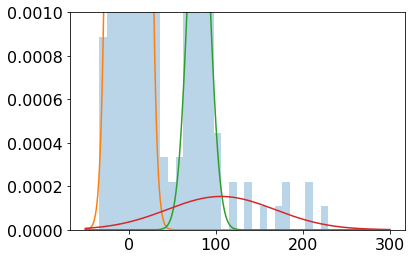

In [89]:
X = torch.arange(-50,300,0.1)
posterior = dist.Normal(pyro.param("auto_locs")[0], pyro.param("auto_scale")[0])
Y1 = torch.exp(posterior.log_prob(X))
posterior = dist.Normal(pyro.param("auto_locs")[1], pyro.param("auto_scale")[1])
#posterior = dist.Gamma(60, 0.3)
Y2 = torch.exp(posterior.log_prob(X))
posterior = dist.Normal(pyro.param("auto_locs")[2], pyro.param("auto_scale")[2])
Y3 = torch.exp(posterior.log_prob(X))

plt.hist(data, bins=30, density=True, alpha=0.3)
plt.plot(X.cpu().numpy(), Y1.data.cpu().numpy()*pyro.param("auto_weights")[0].item(), label="0")
plt.plot(X.cpu().numpy(), Y2.data.cpu().numpy()*pyro.param("auto_weights")[1].item(), label="1")
plt.plot(X.cpu().numpy(), Y3.data.cpu().numpy()*pyro.param("auto_weights")[2].item(), label="2")
plt.ylim(0,0.001)
plt.show()

In [127]:
@interact
def view_trace(aoi=aoi):
    plt.figure(figsize=(15,4))
    plt.plot(smd["trace"][aoi].index, smd["trace"][aoi]["intensity"]/5000-3)
    plt.plot(smd["trace"][aoi].index, pyro.param("z_probs")[:,0].detach().numpy())
    plt.xlabel("frame #")
    plt.ylabel("integrated intensity")
    
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=83, description='aoi', max=249, min=-83), Output()), _dom_classes=('widg…

# Modelv1

## Initiate Models

In [13]:
# init
#model_name = "Feature"
model_name = "v2r"
# gaussian spot model + gamma noise model
spot_models[model_name] = Modelv2
noise_models[model_name] = GammaNoise

Model = type(model_name, (spot_models[model_name],noise_models[model_name]),{}) # change here

models[model_name] = Model(data, K=2) # change here

writers[model_name] = SummaryWriter(log_dir=os.path.join(path,"runs/Modelv2/{}/K{}".format(
    models[model_name].__class__.__name__, models[model_name].K)))

## Choose the model

In [14]:
model_name = "v2r"

model = models[model_name]
writer = writers[model_name]

## Train the model

In [15]:
pyro.clear_param_store()

optim = pyro.optim.Adam({"lr": 0.003, "betas": [0.9, 0.999]})
elbo = TraceEnum_ELBO(max_plate_nesting=5)
#elbo = Trace_ELBO()
svi = SVI(model.model, model.guide, optim, loss=elbo)


writer.add_text("Spot Model", inspect.getsource(spot_models[model_name])) # change here
writer.add_text("Noise Model", inspect.getsource(noise_models[model_name])) # change here

epoch_count = 0
batch_size = 16
#write_summary(epoch_count, batch_size, model, svi, writer, feature=False, mcc=False)

In [16]:
#optim = pyro.optim.Adam({"lr": 0.005, "betas": [0.9, 0.999]})
#elbo = TraceEnum_ELBO()
#elbo = Trace_ELBO()
#svi = SVI(model.model, model.guide, optim, loss=elbo)

In [23]:
n_epochs = 15

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx in DataLoader(Sampler(model.N), batch_size=16, shuffle=True):
        for frame_idx in DataLoader(Sampler(model.F), batch_size=32, shuffle=True):
            loss = svi.step(batch_idx, frame_idx)
            epoch_loss += loss * len(batch_idx) * len(frame_idx) / (model.N * model.F)
        
    #if not epoch_count % 5:
    #print(epoch_loss)
    write_summary(epoch_count, epoch_loss, model, svi, writer, feature=False, mcc=False)
    epoch_count += 1
    
# cpu 22s/it
# gpu 14s/it double sampling

100%|██████████| 15/15 [13:18<00:00, 52.72s/it]


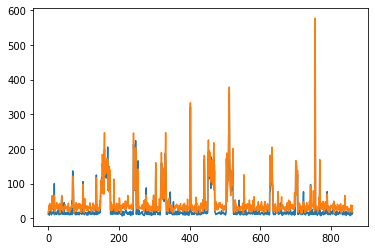

In [27]:
plt.plot(pyro.param("h_loc").squeeze().detach().cpu().numpy()[147])
plt.plot(data.h.cpu().numpy()[147])
plt.show()

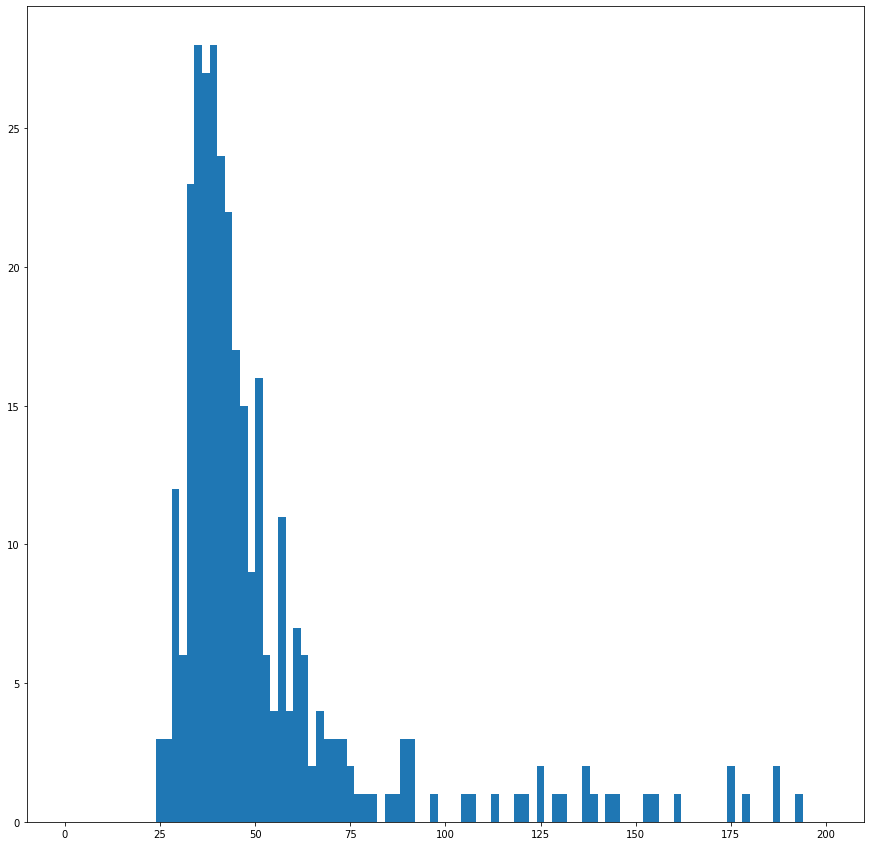

In [43]:
plt.figure(figsize=(15,15))
plt.hist(pyro.param("h_loc").squeeze().detach().cpu().numpy(), bins=100, range=(0,200))
plt.show()

### Simulations

In [ ]:
sample_data = model.sample()

In [ ]:
for k in range(model.K):
    writer.add_histogram("hist_class_{}".format(k), model.data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 0)
    writer.add_histogram("hist_class_{}".format(k), sample_data[torch.tensor(
        (model.data.info["predictions"] == k).values)].reshape(-1).cpu(), 1)
    
    for i in range(model.D**2):
        x, y = divmod(i, model.D)
        writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), model.data[torch.tensor((model.data.info["predictions"] == k).values)]
         [:, x, y], 0)
        writer.add_histogram("pixel_{}_{}_class_{}".format(x,y,k), sample_data[torch.tensor((model.data.info["predictions"] == k).values)]
         [:, x, y], 1)

# Classification

In [18]:
# class based on the highest probability
model.data.predictions = pyro.param("z_probs").squeeze().detach().argmax(dim=2)
# probabilities
model.data.probs = pyro.param("z_probs").squeeze().detach()

In [40]:
#torch.save(data.probs, os.path.join(path, "probs.pt"))

In [51]:
pyro.param("h_loc").squeeze()[10]

tensor(67.1787, grad_fn=<SelectBackward>)

In [19]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_aoi_summary, aoi=aoi_widget, data=fixed(data), show_class=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi_summary(aoi, data, show_class=False)>

In [20]:
aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(data.target.index)])

interact(view_feature_summary, aoi=aoi_widget, data=fixed(data))

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_feature_summary(aoi, data, show_class=False)>

In [24]:
frame_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(model.data.drift.index)])

aoi_widget = widgets.Dropdown(options=[(j,i) for i,j in enumerate(model.data.target.index)])

interact(view_aoi, aoi=aoi_widget, frame=frame_widget, data=fixed(model.data), show_class=True)

interactive(children=(Dropdown(description='aoi', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

<function utils.view_aoi(aoi, frame, data, show_class=False)>

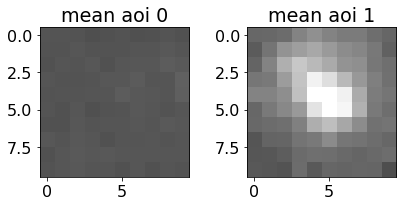

In [41]:
view_aoi_class_average(model.data, model.K)

In [ ]:
# interesting cases
# aoi 83 frame 2553 frame 2980 frame 3307

# Fitting results

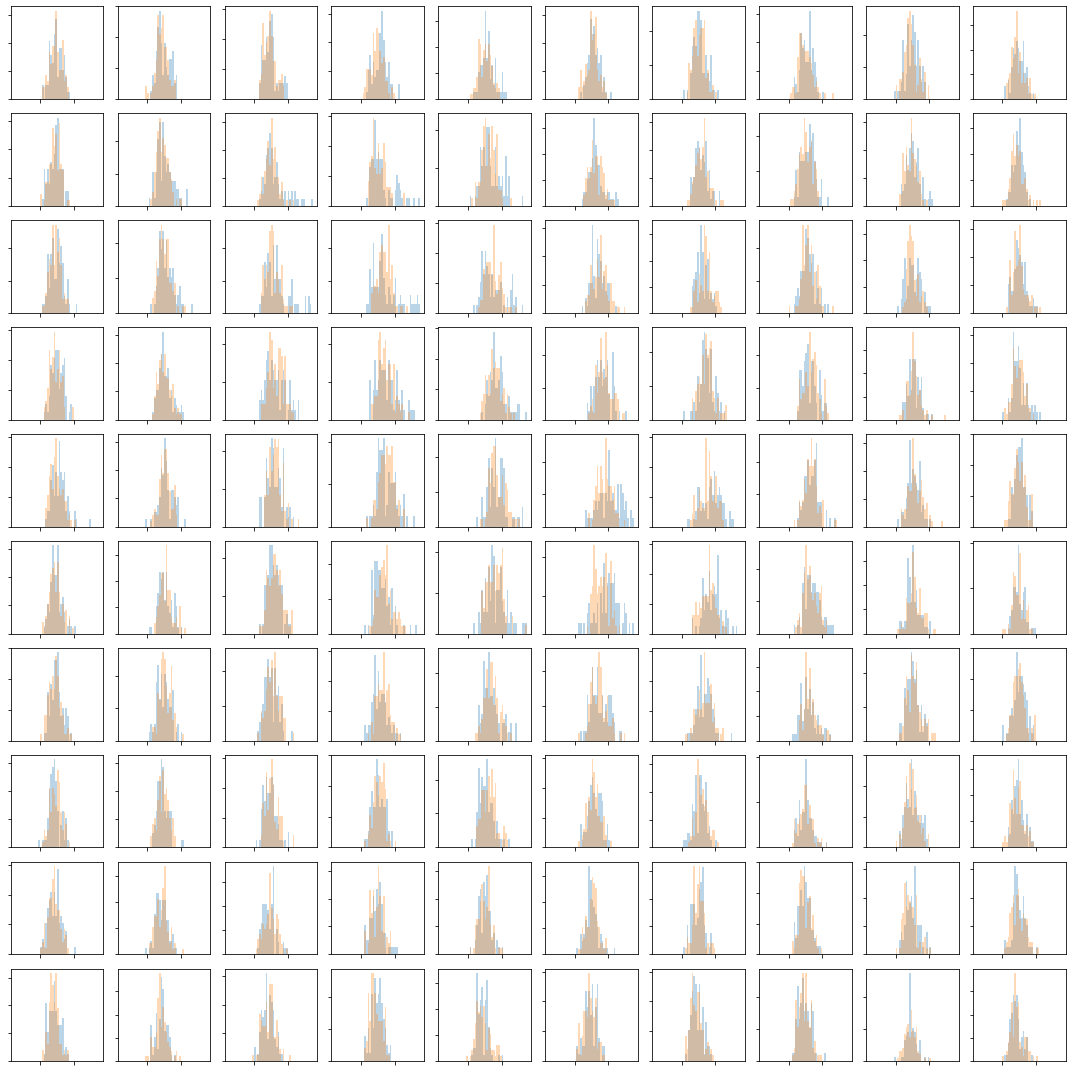

In [141]:
plt.figure(figsize=(15,15))
for i in range(gmm.D**2):
    plt.subplot(gmm.D,gmm.D,i+1)
    plt.hist(spot_data.reshape(-1,100)[:,i], bins=50, alpha=0.3, density=True, range=(50,550))
    plt.hist(sample_data.reshape(-1,100)[sample_z == 2,i], bins=50, alpha=0.3, density=True, range=(50,550))
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

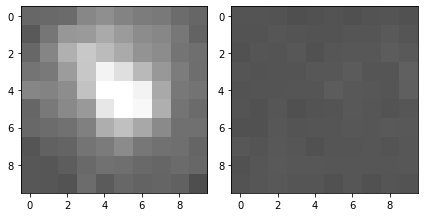

In [142]:
vmin = np.percentile(smd["data"][aoi].cpu(), 5)
vmax = np.percentile(smd["data"][aoi].cpu(), 99)
plt.subplot(1,2,1)
plt.imshow(spot_data.mean(dim=0).cpu(), cmap='gray', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(nospot_data.mean(dim=0).cpu(), cmap='gray', vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

In [166]:
smd["trace"][aoi].loc[2230:2240].index

Int64Index([2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240], dtype='int64', name='frame')

In [163]:
smd["trace"][aoi]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [190]:
(framelist_df.loc[(framelist_df["aoi"] == 47) & (framelist_df["frame"] == 2707), "detected"] == 1).bool()

True

In [164]:
import matplotlib.patches as patches
from copy import copy

rect = patches.Rectangle((0,0),9,9,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((0.5,0.5),8,8,linewidth=3,edgecolor='b',facecolor='none')

# 11 2252
# 17 2070 22 1181
@interact
def view_aoi(aoi=aoi, frame=smd["trace"][aoi].index):
    frames = smd["trace"][aoi].loc[frame:].index
    #frame = 345
    fig = plt.figure(figsize=(15,6))
    for i in range(10):
        #print(i)
        ax = fig.add_subplot(2,5,i+1)
        plt.title("f {:d}".format(frames[i]))
        vmin = np.percentile(smd["data"][aoi].cpu(), 5)
        vmax = np.percentile(smd["data"][aoi].cpu(), 99)
        plt.imshow(smd["data"][aoi][smd["trace"][aoi].index.get_loc(frames[i])].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
        #plt.scatter(smd["trace"][aoi].at[frames[i], "x"], smd["trace"][aoi].at[frames[i], "y"], marker="x", s=100, c="r")
        if smd["trace"][aoi].at[frames[i],"z1"] > 0.5:
            new_rect = copy(rect)
            ax.add_patch(new_rect)
        if smd["trace"][aoi].at[frames[i],"z2"] > 0.5:
            new_rect = copy(rect2)
            ax.add_patch(new_rect)
        #if (framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["frame"] == frames[i]), "detected"] == 1).bool():
        #    new_rect = copy(rect2)
        #    ax.add_patch(new_rect)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=83, description='aoi', max=249, min=-83), Dropdown(description='frame', …

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

def surface_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return surf

def wireframe_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_wireframe(x, y, matrix, **kwargs)
    return surf

def scatter_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.scatter(x, y, matrix, **kwargs)
    return surf


fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(221, projection='3d')
surf = surface_plot(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2500)].numpy(), ax, cmap=plt.cm.coolwarm)
#surf = scatter_plot(smd["data"][0,97].cpu().numpy(), ax, cmap=plt.cm.coolwarm)
#fig.colorbar(surf)
#frame1 = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_zlim(0,500)
#ax.set_xlabel('X (cols)')
#ax.set_ylabel('Y (rows)')
#ax.set_zlabel('Z (values)')

ax = fig.add_subplot(222, projection='3d')
surf = surface_plot(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2715)].numpy(), ax, cmap=plt.cm.coolwarm)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_zlim(0,500)

plt.pause(0.1)

In [239]:
smd["data"][aoi][smd["trace"][aoi].index.get_loc(2898)]

tensor([[294., 297., 274., 396., 274., 331., 315., 350., 402., 274.],
        [353., 327., 324., 363., 366., 261., 319., 251., 341., 280.],
        [326., 350., 292., 272., 319., 246., 364., 279., 284., 307.],
        [219., 337., 291., 283., 283., 300., 296., 321., 326., 287.],
        [281., 290., 276., 327., 287., 290., 354., 300., 238., 284.],
        [256., 316., 315., 349., 333., 301., 327., 312., 311., 313.],
        [310., 274., 343., 291., 342., 276., 363., 358., 354., 336.],
        [269., 284., 322., 352., 262., 263., 329., 319., 321., 362.],
        [300., 335., 284., 264., 287., 323., 296., 227., 258., 344.],
        [283., 303., 307., 324., 377., 314., 382., 297., 361., 292.]])

In [240]:
smd["data"][aoi][smd["trace"][aoi].index.get_loc(2903)]

tensor([[304., 335., 335., 347., 307., 317., 319., 294., 302., 288.],
        [381., 301., 335., 312., 321., 299., 313., 304., 319., 266.],
        [308., 276., 293., 352., 303., 290., 275., 330., 392., 288.],
        [342., 320., 388., 302., 247., 307., 313., 331., 357., 409.],
        [322., 339., 378., 249., 280., 313., 297., 291., 263., 391.],
        [281., 321., 310., 334., 321., 275., 305., 370., 280., 328.],
        [345., 321., 346., 308., 309., 265., 295., 339., 317., 351.],
        [309., 327., 278., 288., 220., 327., 351., 267., 338., 307.],
        [377., 289., 342., 240., 322., 287., 345., 258., 310., 354.],
        [367., 271., 297., 316., 264., 276., 294., 225., 374., 283.]])

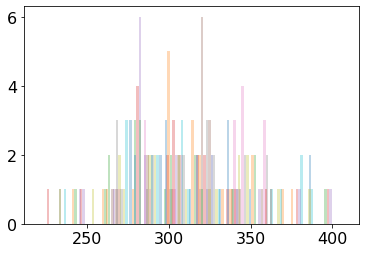

In [232]:
plt.hist(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2898)], alpha=0.3)
plt.hist(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2903)], bins=10, alpha=0.3)
plt.show()

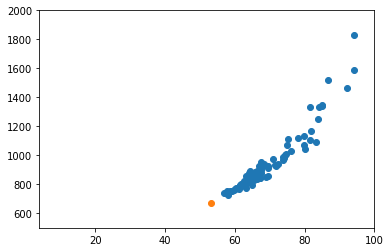

In [362]:
plt.scatter(data[z_p[:,1] > 0.5].mean(dim=0).reshape(-1).numpy(), data[z_p[:,1] > 0.5].var(dim=0).reshape(-1).numpy())
plt.scatter(data[z_p[:,0] > 0.5].mean().reshape(-1).numpy(), data[z_p[:,0] > 0.5].var().reshape(-1).numpy())
#plt.scatter(pyro.param("background_loc").detach(),)
plt.xlim(4,100)
plt.ylim(500,2000)
plt.show()